# 5 - Single Kramers chain analysis
Here we will be only looking at a single chain and what tools are available to plot the dynamics.

In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate
from dilutebrowniandynamics.molecules.Kramers_chain import KramersChain
np.random.seed(2022)

## Parameters definition

In [2]:
n_links = 100       # Number of segments in the Kramers chain

n_rec = 2000        # Number of time steps to record
dt = .001           # Time step value (dimensionless)
n_proc = 16         # Number of processor cores to use

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
# Starting vectors
molecule = KramersChain.from_normal_distribution(n_links)

We can plot this molecule using matplotlib 3d capabilities: firt we need to convert links to coordinates.

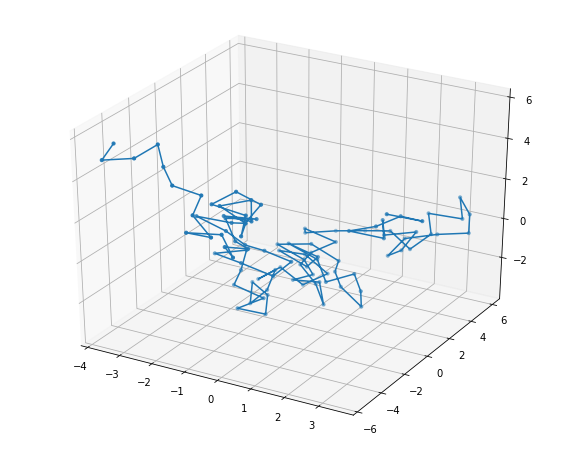

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xyz = molecule.coordinates
x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
ax.plot(x, y, z)
ax.scatter(x, y, z, s=10)

Or we can export the molecule to vtk format which can be read by Paraview.

In [5]:
molecule.save_vtk('outputs/vtk/example.vtk')

## Initial relaxation
Thermalisation step.

In [6]:
gradU = np.zeros((3, 3))
observables, molecule_out = simulate(molecule, gradU, n_rec, dt, full_trajectory=False)

## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [7]:
from scipy.interpolate import interp1d
t_base = [0, # Elongation starts at t = 0
          10] # Relaxation will start from t = 1
gradU_base = [np.diag([1, -.5, -.5]),
              np.zeros((3, 3))]
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [8]:
n_rec = 10_000
observables, trajectory = simulate(molecule_out, gradU, n_rec, dt, full_trajectory=True)

## Analysing tensions in the molcule
Save a sequence of vtk files to make an animation in Paraview:

In [9]:
for i in range(0,len(trajectory),100):
    trajectory[i].save_vtk(f'outputs/vtk/time_{i}.vtk')

To see how the molecule unravels, we can plot tension as function of time in a 2d plot:

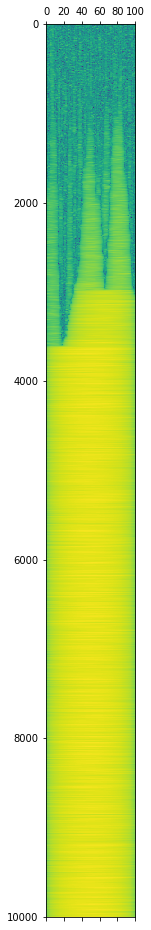

In [10]:
mat = np.empty((n_rec,n_links))
for i in range(n_rec):
    mat[i] = trajectory[i].tensions
    
plt.matshow(np.log(abs(mat)), aspect=0.1)

In [11]:
#%load_ext line_profiler

#%lprun -f KramersChain.evolve molecule_out.evolve(np.diag([1, -.5, -.5]), 0.00001)